In [1]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn

data_path = './../../data/processed/'

import json
vardict = json.load(open("variables.json"))
def add_entry(vardict, name, element):
    vardict[name]= element
    return vardict

# args = ['variable2', x.]
# res = add_entry(vardict, *args)

## May diversification follow a power law? 
It seems so for small numbers, but there is a saturation...

In [2]:
#load effective distribution data (processed from previous cells) and store in list of lists

wn_ID_distrib_list = []
for j, col in enumerate(['CN ID 4', 'PYOD', 'VAT']):
    wn_ID_distrib_list_j = []
    for i in [0, 1]:
        if (i == 1 and col == 'VAT'): 
            pass
        else:
            
#         wn_ID_distrib = wn_ID_distrib_list[j][i]
            wn_ID_distrib = pd.read_csv(data_path + 'wn_ID_distrib_'+col.replace(' ','_')+'_'+['Exp', 'Imp'][i])
        wn_ID_distrib_list_j += [wn_ID_distrib] # A list for each of the columns (products, countries, VAT)
    wn_ID_distrib_list += [wn_ID_distrib_list_j] # This list has the summary results, used for ex. for barcharts


/home/miglesia/anaconda2/envs/my_pymc_env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log10
/home/miglesia/anaconda2/envs/my_pymc_env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log10
/home/miglesia/anaconda2/envs/my_pymc_env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10
/home/miglesia/anaconda2/envs/my_pymc_env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log10


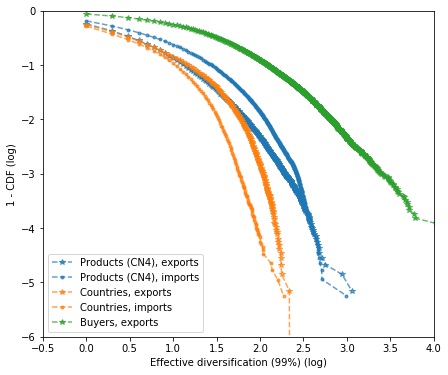

In [3]:
# CUMULATIVE

fig, axs = plt.subplots(1, figsize = (7, 6))

for j, col in enumerate(['CN ID 4', 'PYOD', 'VAT']):
    info_list = []
    for i in [0, 1]:
        if (i == 1 and col == 'VAT'): 
            pass
        else:
            
            wn_ID_distrib = wn_ID_distrib_list[j][i]
#             wn_ID_distrib = pd.read_csv('./../../data/processed/wn_ID_distrib_'+col.replace(' ','_')+'_'+['Exp', 'Imp'][i])

            div_distribution = wn_ID_distrib.groupby('ID').count().iloc[:, 0].value_counts().sort_index()
            div_distribution/=div_distribution.sum()
            div_distribution = div_distribution.cumsum().reset_index()
            div_distribution['log_divers'] = np.log10(div_distribution['index'])
            div_distribution['1-CDF'] = np.log10(1 - div_distribution.iloc[:, 1])


            ax = axs
            div_distribution.plot(x = 'log_divers', y = div_distribution.columns[-1], ax = ax, marker = ['*', '.'][i], 
                                       color = ['#1f77b4', '#ff7f0e', '#2ca02c'][j], linestyle = '--', alpha = .7,
                                      label = ['Products (CN4), ', 'Countries, ', 'Buyers, '][j] + ['exports', 'imports'][i])
plt.ylabel('1 - CDF (log)')
plt.xlabel('Effective diversification (99%) (log)')
plt.legend()
plt.ylim(-6, 0)
plt.xlim(-.5, 4)
plt.savefig('./../../../thesis_writing/figures/diversity_distrib_1-CDF_loglog.png', dpi = 300)
plt.show()



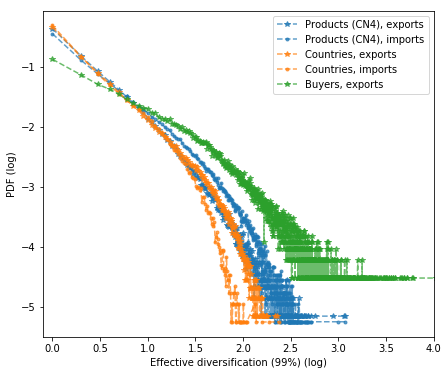

In [4]:
# PDF

fig, axs = plt.subplots(1, figsize = (7, 6))

for j, col in enumerate(['CN ID 4', 'PYOD', 'VAT']):
    info_list = []
    for i in [0, 1]:
        if (i == 1 and col == 'VAT'): 
            pass
        else:
            
            wn_ID_distrib = wn_ID_distrib_list[j][i]
    #         wn_ID_distrib = pd.read_csv('./../../data/processed/wn_ID_distrib_'+col.replace(' ','_')+'_'+['Exp', 'Imp'][i])

            div_distribution = wn_ID_distrib.groupby('ID').count().iloc[:, 0].value_counts().sort_index()
            div_distribution/=div_distribution.sum()
#             div_distribution = div_distribution.cumsum().reset_index()
            div_distribution = div_distribution.reset_index()
            div_distribution['log_divers'] = np.log10(div_distribution['index'])
            div_distribution['log_PDF'] = np.log10(div_distribution.iloc[:, 1])
#             div_distribution['1-CDF'] = np.log10(1 - div_distribution.iloc[:, 1])


            ax = axs
            div_distribution.plot(x = 'log_divers', y = 'log_PDF', ax = ax, marker = ['*', '.'][i], 
                                       color = ['#1f77b4', '#ff7f0e', '#2ca02c'][j], linestyle = '--', alpha = .7,
                                      label = ['Products (CN4), ', 'Countries, ', 'Buyers, '][j] + ['exports', 'imports'][i])
plt.legend()
plt.ylabel('PDF (log)')
plt.xlabel('Effective diversification (99%) (log)')
# plt.ylim(-6, 0)
plt.xlim(-.1, 4)
plt.savefig('./../../../thesis_writing/figures/diversity_distrib_PDF_loglog.png', dpi = 300)
plt.show()



# Assortativity

In [5]:
df = pd.read_csv('./../../data/processed/buyer_seller_link_value.csv')

In [6]:
df.nunique()

IMPORT          1
YEAR            9
ID          80955
VAT       1677466
VART       783763
dtype: int64

In [7]:
wn_ID_distrib.nunique()

VAT         865845
ID           32841
VART        321695
rank         59156
cs_VART    1895409
pdf_ID     1735551
cdf_ID     1932624
dtype: int64

In [8]:
# For IDs I can use effective diversification

nunique_cols = []
for cut in [.9, .99, .999]:
    count = wn_ID_distrib.loc[(wn_ID_distrib.cdf_ID < cut)].groupby('ID')[[col]].count()
    count = count.reindex(wn_ID_distrib.ID.unique()).fillna(0).astype(int) + 1 #this is to count passing the threshold.
    count.columns = [cut]
    nunique_cols += [count]
    
ID_deg = pd.concat(nunique_cols, axis = 1)
ID_deg = ID_deg.add_suffix('_deg')

In [9]:
sizes = wn_ID_distrib.groupby('ID')[['VART']].sum()
sizes.columns = ['ID_VART']

In [10]:
# For VATs, I can just use max. I.e. nunique.

In [11]:
%%time

VAT_deg = wn_ID_distrib.groupby('VAT')[['ID']].nunique()
VAT_deg.columns = ['VAT_deg']

CPU times: user 3.56 s, sys: 4 ms, total: 3.57 s
Wall time: 3.53 s


In [12]:
links_df = wn_ID_distrib.merge(pd.concat([ID_deg, sizes], axis = 1).reset_index()).merge(VAT_deg.reset_index())

links_df['w_VAT_deg'] = links_df['pdf_ID'] * links_df['VAT_deg'] #.sort_values(by = ['ID', 'VART'])

In [13]:
# np.log10(links_df['0.99_deg'].quantile(.99))
# np.power(10, 3.5)

In [14]:
ID_deg_col = '0.99_deg'
links_df = links_df.loc[links_df[ID_deg_col] < 3200]
links_df['bins'] = pd.cut(np.log10(links_df[ID_deg_col]), 50)

In [15]:
VAT_w_deg = links_df.groupby('ID').agg({ID_deg_col: 'mean','ID_VART': 'mean', 'bins': 'first', 'w_VAT_deg': 'sum'})

In [16]:
# VAT_w_deg['bin_total'] = 
bin_VART = VAT_w_deg.groupby('bins')[['ID_VART']].sum()
bin_VART.columns = ['bin_VART']

VAT_w_deg = VAT_w_deg.merge(bin_VART.reset_index())

VAT_w_deg['w_bin_VAT_deg_fraction'] = (VAT_w_deg['w_VAT_deg']*VAT_w_deg['ID_VART'])/VAT_w_deg['bin_VART']

double_w_mean_deg = VAT_w_deg.groupby('bins')['w_bin_VAT_deg_fraction'].sum().reset_index()

In [17]:
double_w_mean_deg['log_deg'] = np.array([i.mid for i in double_w_mean_deg.bins])
double_w_mean_deg['log_w_bin_VAT_deg_fraction'] = np.log10(double_w_mean_deg['w_bin_VAT_deg_fraction'])

In [18]:
sample = VAT_w_deg.groupby('bins').apply(lambda x: x.sample(200, replace = True))
sample = sample.drop_duplicates()
sample['log_w_VAT_deg'] = np.log10(sample['w_VAT_deg'])
sample[ID_deg_col] = np.log10(sample[ID_deg_col])
sample['sizes'] = sample['ID_VART']/1000000.

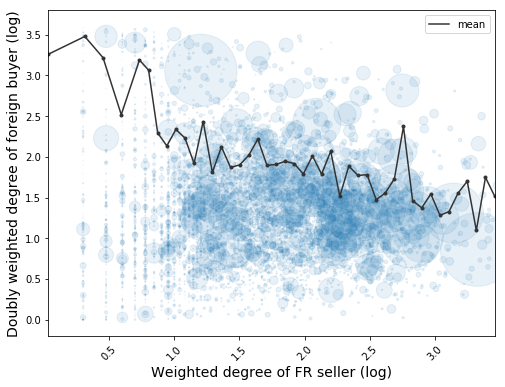

In [25]:
fig, ax = plt.subplots(1, figsize = (8, 6))
double_w_mean_deg.plot(x = 'log_deg', y = 'log_w_bin_VAT_deg_fraction', marker = '.', ax = ax, c = '.2', 
                       label = 'mean')
# ax.set_xscale('log')
ax.set_xlabel('seller degree')
ax.set_ylabel('mean seller degree')

sample.plot(x = ID_deg_col, y = 'log_w_VAT_deg', kind = 'scatter', s = sample['sizes'].values, alpha = .1, ax = ax)

plt.xlabel('Weighted degree of FR seller (log)', fontsize = 14)
plt.ylabel('Doubly weighted degree of foreign buyer (log)', fontsize = 14)

plt.xticks(rotation=45)

plt.savefig('./../../../thesis_writing/figures/doubly_w_assortativity.png', dpi = 300)
plt.show()

In [20]:
#bins of seller size. In each bin, do the sum of (degree of the buyer times the link value)